# 1. Importing and Installing required libraries

In [ ]:
# Install spaCy
!pip install spacy

# Download the English language model
!python -m spacy download en_core_web_sm



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 12.8/12.8 MB 294.4 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install text_hammer

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# importing the dataset
df_train = pd.read_csv(r'C:\Users\dell\Downloads\emo\training.csv')
df_test = pd.read_csv(r'C:\Users\dell\Downloads\emo\test.csv')
df_val=pd.read_csv(r'C:\Users\dell\Downloads\emo\validation.csv')

In [ ]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


# 2. Doing some text preprocessing

In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

    return(df)

In [ ]:
df_cleaned = text_preprocessing(df_full,'text')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
df_cleaned = df_cleaned.copy()

In [ ]:
df_cleaned['num_words'] = df_cleaned['text'].apply(lambda x:len(x.split()))

In [ ]:
# changing the data type to the category to encode into codes
df_cleaned['label'] = df_cleaned['label'].astype('category')

In [ ]:
df_cleaned['label']

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 20000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [ ]:
df_cleaned['label'].cat.codes

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Length: 20000, dtype: int8

In [ ]:
encoded_dict  = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}

In [ ]:
df_cleaned.num_words.max()

66

In [ ]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned['label'])

In [ ]:
data_train.shape

(14000, 3)

In [ ]:
data_test.shape

(6000, 3)

In [ ]:
to_categorical(data_train['label'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

# 3. Now lets load the model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# for saving model locally and we can load it later on
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [ ]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'C:\\Users\\dell\\Downloads\\bert-model.zip'

In [ ]:
tokenizer('I will be kaggle grandmaster')

{'input_ids': [101, 146, 1209, 1129, 24181, 25186, 5372, 6532, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Tokenize the input (takes some time)
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test['input_ids']

<tf.Tensor: shape=(6000, 70), dtype=int32, numpy=
array([[ 101,  178, 1243, ...,    0,    0,    0],
       [ 101,  178, 1631, ...,    0,    0,    0],
       [ 101,  178, 2810, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1838, ...,    0,    0,    0],
       [ 101,  178, 1238, ...,    0,    0,    0],
       [ 101,  178, 4534, ...,    0,    0,    0]])>

In [ ]:
max_len = 70

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(
    learning_rate=5e-05,  # This learning rate is for BERT model, taken from Hugging Face website
    epsilon=1e-08,
    clipnorm=1.0
)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 70)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 70)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 70, 76                                       

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# 4. Model fitting and then evaluation

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=1,
    batch_size=36
)


 13/389 [>.............................] - ETA: 1:06:50 - loss: 1.7117 - balanced_accuracy: 0.3205WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


 27/389 [=>............................] - ETA: 1:05:24 - loss: 1.6276 - balanced_accuracy: 0.3570WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


 41/389 [==>...........................] - ETA: 1:03:05 - loss: 1.5039 - balanced_accuracy: 0.4336WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


 55/389 [===>..........................] - ETA: 1:00:41 - loss: 1.3940 - balanced_accuracy: 0.4823WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


 69/389 [====>.........................] - ETA: 58:22 - loss: 1.3118 - balanced_accuracy: 0.5181WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


 83/389 [=====>........................] - ETA: 55:57 - loss: 1.2058 - balanced_accuracy: 0.5612WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


 97/389 [======>.......................] - ETA: 53:33 - loss: 1.1368 - balanced_accuracy: 0.5919WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


111/389 [=======>......................] - ETA: 50:59 - loss: 1.0661 - balanced_accuracy: 0.6224WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


125/389 [========>.....................] - ETA: 48:27 - loss: 0.9954 - balanced_accuracy: 0.6496WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


139/389 [=========>....................] - ETA: 45:56 - loss: 0.9401 - balanced_accuracy: 0.6725WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


153/389 [==========>...................] - ETA: 43:27 - loss: 0.8889 - balanced_accuracy: 0.6917WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


167/389 [===========>..................] - ETA: 41:01 - loss: 0.8479 - balanced_accuracy: 0.7076WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


181/389 [============>.................] - ETA: 38:24 - loss: 0.8081 - balanced_accuracy: 0.7219WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


195/389 [==============>...............] - ETA: 35:49 - loss: 0.7709 - balanced_accuracy: 0.7355WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


209/389 [===============>..............] - ETA: 33:13 - loss: 0.7445 - balanced_accuracy: 0.7448WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


223/389 [================>.............] - ETA: 30:38 - loss: 0.7188 - balanced_accuracy: 0.7550WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


237/389 [=================>............] - ETA: 28:06 - loss: 0.6911 - balanced_accuracy: 0.7652WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


251/389 [==================>...........] - ETA: 25:34 - loss: 0.6694 - balanced_accuracy: 0.7716WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


265/389 [===================>..........] - ETA: 23:02 - loss: 0.6510 - balanced_accuracy: 0.7779WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


279/389 [====================>.........] - ETA: 20:29 - loss: 0.6308 - balanced_accuracy: 0.7849WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


293/389 [=====================>........] - ETA: 17:54 - loss: 0.6120 - balanced_accuracy: 0.7906WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


307/389 [======================>.......] - ETA: 15:18 - loss: 0.5938 - balanced_accuracy: 0.7961WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


321/389 [=======================>......] - ETA: 12:43 - loss: 0.5794 - balanced_accuracy: 0.7999WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


335/389 [========================>.....] - ETA: 10:06 - loss: 0.5650 - balanced_accuracy: 0.8046WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


349/389 [=========================>....] - ETA: 7:29 - loss: 0.5513 - balanced_accuracy: 0.8092WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


363/389 [==========================>...] - ETA: 4:52 - loss: 0.5378 - balanced_accuracy: 0.8137WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


377/389 [============================>.] - ETA: 2:15 - loss: 0.5259 - balanced_accuracy: 0.8177WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?


389/389 [==============================] - 4891s 13s/step - loss: 0.5163 - balanced_accuracy: 0.8207 - val_loss: 0.1808 - val_balanced_accuracy: 0.9257


# 5.Prediction Part

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

188/188 [==============================] - 505s 3s/step


In [ ]:
predicted_raw[0]

array([0.16821241, 0.99482346, 0.11326693, 0.04361805, 0.02741484,
       0.13390426], dtype=float32)

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([1, 1, 1, ..., 0, 0, 4], dtype=int64)

In [ ]:
data_test['label']

2950     1
11631    1
8685     1
10305    0
11829    0
        ..
2666     1
6556     3
14591    0
1748     3
4950     4
Name: label, Length: 6000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [ ]:
accuracy_score(data_test['label'],y_predicted)

0.9256666666666666

In [ ]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1739
           1       0.96      0.93      0.95      2028
           2       0.80      0.90      0.85       492
           3       0.94      0.91      0.92       813
           4       0.83      0.94      0.88       712
           5       0.92      0.73      0.81       216

    accuracy                           0.93      6000
   macro avg       0.90      0.89      0.90      6000
weighted avg       0.93      0.93      0.93      6000



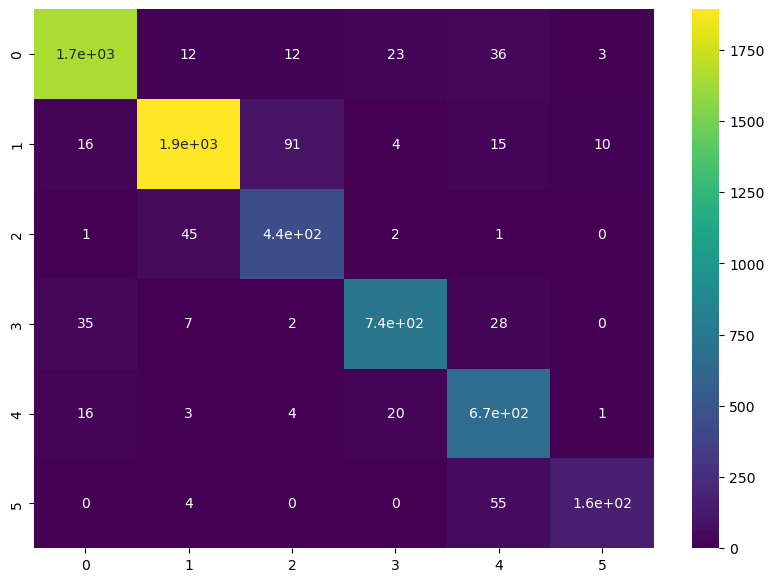

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

# 5. Prediction on custom text

In [ ]:
texts = input(str('input the text'))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

input the textI am sitting alone and I just do it everyday
1/1 [==============================] - 0s 382ms/step


array([[86.438   , 51.73469 , 20.117455, 73.45819 , 88.80104 , 16.299204]],
      dtype=float32)

In [ ]:
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

anger 86.438
fear 51.73469
joy 20.117455
love 73.45819
sadness 88.80104
surprise 16.299204
